In [0]:
import warnings
import re
from PIL import Image
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings('ignore')
# display options for pandas dataframe
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)
# pd.reset_option('display.max_colwidth')

/kaggle/input/movielens-20m-dataset/movie.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv


In [0]:
movies = pd.read_csv('/kaggle/input/movielens-20m-dataset/movie.csv')
ratings = pd.read_csv('/kaggle/input/movielens-20m-dataset/rating.csv')
gnomeS = pd.read_csv('/kaggle/input/movielens-20m-dataset/genome_scores.csv')
gnomeT = pd.read_csv('/kaggle/input/movielens-20m-dataset/genome_tags.csv')

In [0]:
# clean title in movies.csv file
def movie_title_clean(title):
  
  # search title for (year) pattern
  s = re.search('\(([^)]+)', title)

  # if pattern exists, remove from string
  year = 9999
  if s:
    title = title[:s.span()[0]].strip()
    year = s.group(1)
    
    if str(year).isdigit():
      year = int(year)
    else:
      year = 9999  
  
  # if ', The' or ', A' is a the end of the string, move it to the front
  # e.g. change "Illusionist, The" to "The Illusionist"
  if title[-5:] == ', The':
    title = 'The ' + title[:-5]
  elif title[-4:] == ', An':
    title = 'An ' + title[:-4]
  elif title[-3:] == ', A':
    title = 'A ' + title[:-3]
    
  return title, year

In [0]:
# clean title and extract release year
def prepareMovies(df):
    df['title'] = df['title'].str.strip()
    df['Title_Year'] = df['title'].map(movie_title_clean)
    df['Title'] = df['Title_Year'].apply(lambda x: x[0])
    df['Release Year'] = df['Title_Year'].apply(lambda x: x[1])
    return df

In [0]:
def getGenres(df):
    df = prepareMovies(df)
    movies_stack = df[df['genres'] != '(no genres listed)'].set_index('movieId').genres.str.split('|', expand = True).stack()
    movies_explode = pd.get_dummies(movies_stack, prefix = 'g').groupby(level = 0).sum().reset_index()
    del movies_stack
    movies_explode['genre_vector'] = movies_explode.iloc[:,1:].values.tolist()
    df = df.merge(movies_explode[['movieId','genre_vector']], on = 'movieId', how = 'left')
    return df

In [0]:
print('number of tags', len(np.unique(gnomeT.tagId.values)))
print('number of movies', len(np.unique(gnomeS.movieId.values)))
print('number of movie, tag pairs', len(gnomeS))

number of tags 1128
number of movies 10381
number of movie, tag pairs 11709768


In [0]:
movWithGenre = getGenres(movies) 

In [0]:
def boxPlot(tags):
    sns.set(style="whitegrid")
    f, ax = plt.subplots(figsize=(20, 6))
    ax = sns.boxplot(x = "relevance_rank", y = "relevance", data = tags[tags.relevance_rank <= 50], showfliers = True)
    ax.set(ylabel = "Relevance Score")
    ax.set(xlabel = "Relevance Rank")
    plt.title("Box Plot: Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')
    plt.figure().savefig('boxplot.png')

In [0]:
def plotPCT(tags_rank):
    f, ax = plt.subplots(figsize=(10, 6))
    ax = sns.lineplot(x="relevance_rank", y="relevance_median_pct_chg", data = tags_rank)
    ax.set(ylabel = "% Change in Median Relevance Score")
    ax.set(xlabel = "Relevance Rank")
    plt.title("% Change in Tag Relevance Score by Rank", fontsize = 20, weight = 'bold')
    plt.figure().savefig('pct_chng.png')

In [0]:
def getRelevantTags(mov, gS, gT):
    tags = gS.merge(gT, on = 'tagId').merge(mov, on = 'movieId')
    tags['relevance_rank'] = tags.groupby("movieId")["relevance"].rank(method = "first", ascending = False).astype('int64')
    # compute median relevance score for each relevance rank
    #boxPlot(tags)
    tags_rank = tags.groupby('relevance_rank')['relevance'].median().reset_index(name = 'relevance_median').head(100)
    tags_rank['relevance_median_pct_chg'] = tags_rank['relevance_median'].pct_change()
    #plotPCT(tags_rank)
    # flatten tags table to get a list of top 100 tags for each movie
    tags_list = tags[tags.relevance_rank <= 100].groupby(['movieId','Title'])['tag'].apply(lambda x: ','.join(x)).reset_index()
    tags_list['tag_list'] = tags_list.tag.map(lambda x: x.split(','))
    return tags_list

In [0]:
def plotWordCloud(text):
    plt.rcParams["figure.figsize"] = (15,10)

    # Generate a word cloud image
    wordcloud = WordCloud(width = 1024, height = 1024, background_color = 'black').generate(text)

    # Display the generated image:
    plt.figure(figsize=(10,8),facecolor = 'black', edgecolor='lightblue')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.figure().savefig('words.png')

In [0]:
pd.reset_option('display.max_colwidth')
def relatedmovies(title):
    target_movie = title
    movWithGenre = getGenres(movies)
    tags_list = getRelevantTags(movWithGenre, gnomeS, gnomeT)
    target_tag_list = tags_list.loc[tags_list.Title == target_movie, ['movieId','Title','tag_list']].tag_list.values[0]
    tags_list_sim = tags_list[['movieId','Title','tag_list','tag']]
    tags_list_sim['jaccard_sim'] = tags_list_sim.tag_list.map(lambda x: len(set(x).intersection(set(target_tag_list))) / len(set(x).union(set(target_tag_list))))
    print(f'Movies most similar to {target_movie} based on tags:')
    text = ','.join(tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False).head(25)['tag'].values)
    plotWordCloud(text)
    related = tags_list_sim.sort_values(by = 'jaccard_sim', ascending = False)[['movieId', 'Title']].head(10)
    return tags_list, related

Movies most similar to Grumpier Old Men based on tags:


,movieId,Title
2,3,Grumpier Old Men
407,432,City Slickers II: The Legend of Curly's Gold
390,415,Another Stakeout
117,122,Boomerang
395,420,Beverly Hills Cop III
1497,1703,For Richer or Poorer
3042,3450,Grumpy Old Men
1886,2151,The Gods Must Be Crazy II
3,4,Waiting to Exhale
4675,5309,Three Men and a Little Lady


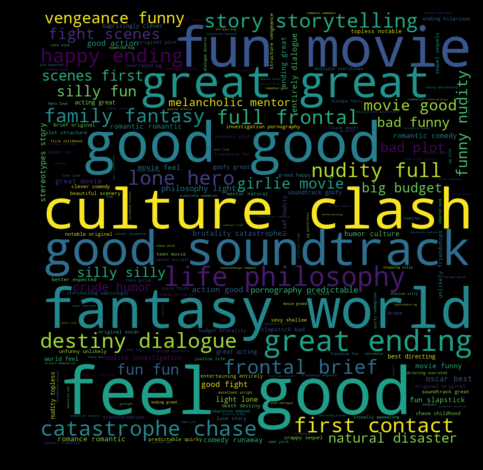

<Figure size 1080x720 with 0 Axes>

In [0]:
#recommendations on basis of TAGS
tags_list, related = relatedmovies('Grumpier Old Men')
related

In [0]:
def getAverage(related, movies, ratings):
    k = pd.merge(related, ratings).drop(['userId', 'timestamp'], axis=1)
    k = k.groupby(('movieId', 'Title'))['rating'].mean().sort_values(ascending=False)
    return k

In [0]:
getAverage(related, movies, ratings)

,movieId,Title,rating
0,3,Grumpier Old Men,4.0
1,3,Grumpier Old Men,3.0
2,3,Grumpier Old Men,3.0
3,3,Grumpier Old Men,5.0
4,3,Grumpier Old Men,3.0
...,...,...,...
59562,5309,Three Men and a Little Lady,2.0
59563,5309,Three Men and a Little Lady,3.5
59564,5309,Three Men and a Little Lady,1.5
59565,5309,Three Men and a Little Lady,2.5
